<a href="https://colab.research.google.com/github/Endalebob/deep-learning/blob/main/Student_Attendance_with_using_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5234418%2F8722734%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240618%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240618T164820Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f78be339de9960b65e2a3dedb2087fc2d1509c861607b73356159fc683fc9a43bd33874c06d948ee535bfe76f17858de53796e7bfd25c084b1304ffa698f6909fcca3ee5dca1557a91f710d4b2633c5c5ef114a0a0225d9bccafcb3b65a1ff677bf9555559a029241a100b3e2cf682199fabe81d67ca106e6ff1b021b10221d7a3ea4326787bd74af982dc8303d409c91a40773a774a8ebd35744b92c86b09c82e2abddc4d9f9e006d6115f5e656527aaade77edc049baa3125809440e309df121c52bc91d3c4608e88b2d552b6a27124cfa087912579edc32f8d05f0f4d7356634f6b1ed95d3a29afdee3add90327b67fb7c54e4f23b063f185580266c3495'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


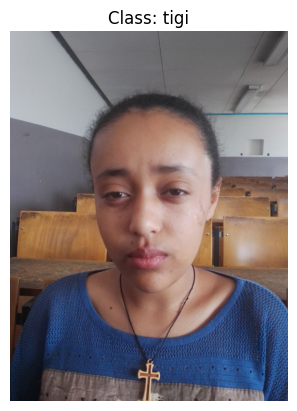

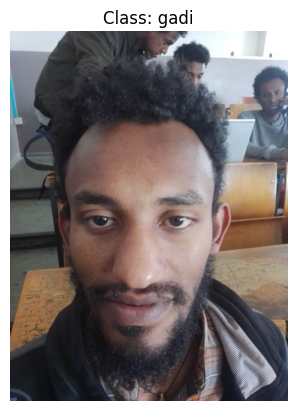

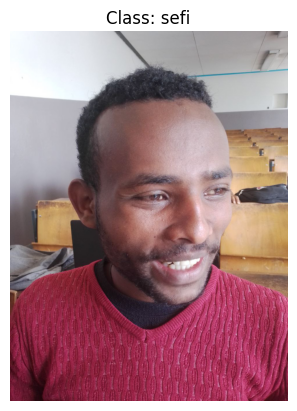

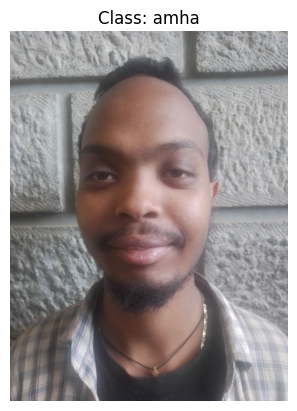

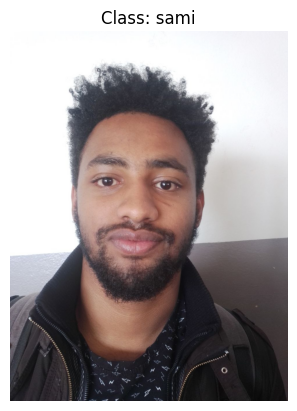

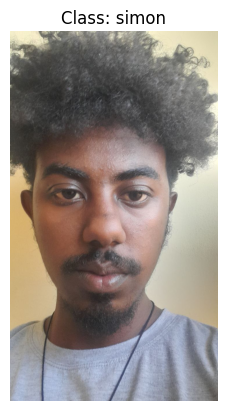

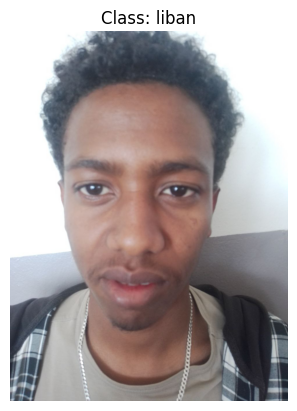

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = '/kaggle/input/dataset/'  # Update this path if needed

# Function to display images
def display_images_from_directory(directory):
    # Iterate over each class folder
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Iterate over each image in the class folder
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if image_path.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file extensions
                    # Open and display the image
                    img = Image.open(image_path)
                    plt.imshow(img)
                    plt.title(f'Class: {class_name}')
                    plt.axis('off')  # Hide the axes
                    plt.show()
                    break

# Call the function to display images
display_images_from_directory(dataset_dir)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Define paths
train_data_dir = '/kaggle/input/dataset/'  # Update this path if needed

# Check if the dataset directory exists and contains subdirectories
if not os.path.isdir(train_data_dir) or len(os.listdir(train_data_dir)) == 0:
    raise ValueError(f"Dataset directory '{train_data_dir}' is empty or does not exist.")

# Image data generator for training and validation
train_datagen = ImageDataGenerator(rescale=0.2, validation_split=0.2)

# Check the number of images in each class
for class_name in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        if num_images < 5:
            raise ValueError(f"Class '{class_name}' has less than 5 images. Add more images or reduce the validation split.")

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Check if enough images are loaded for training and validation
if train_generator.samples == 0:
    raise ValueError("No training images found. Check the dataset directory and ensure it contains images.")
if validation_generator.samples == 0:
    raise ValueError("No validation images found. Check the dataset directory and ensure it contains enough images to split.")

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Dynamically setting number of classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Save the trained model
model.save('student_model.h5')

print("Model training completed and saved as 'student_model.h5'")


Found 56 images belonging to 7 classes.
Found 7 images belonging to 7 classes.
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1131 - loss: 64.4768 - val_accuracy: 0.2857 - val_loss: 85.0296
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step - accuracy: 0.2277 - loss: 84.9127 - val_accuracy: 0.4286 - val_loss: 8.4821
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - accuracy: 0.2778 - loss: 8.9751 - val_accuracy: 0.2857 - val_loss: 2.5660
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.4375 - loss: 2.4299 - val_accuracy: 0.7143 - val_loss: 0.5226
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.8611 - loss: 0.4709 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 6.5844e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
classes = {0:"Amha", 1:"Gadi", 2:"Liban", 3:"Sami", 4:"Sefi", 5:"Simon", 6:"Tigi"}

# Load the trained model
model = tf.keras.models.load_model('student_model.h5')

def predict_student(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    return predicted_class

# Example usage
img_path = '/kaggle/input/dataset/simon/photo_2023-02-18_13-45-45.jpg'
predicted_class = predict_student(img_path)
print(f'Predicted student name: {classes[predicted_class]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted student name: Simon
